In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import mnist_data_lib
import mnist_vae_lib
import vae_utils

import gumbel_training_lib as gum_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import sys
sys.path.insert(0, '../../../rb_utils/')
import gumbel_softmax_lib as gs_lib

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6
num_train_unlabled:  54
num_test:  10


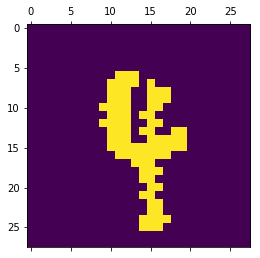

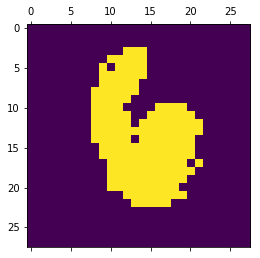

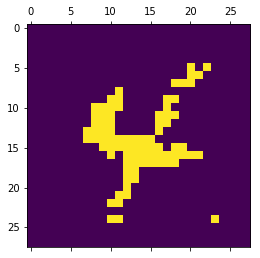

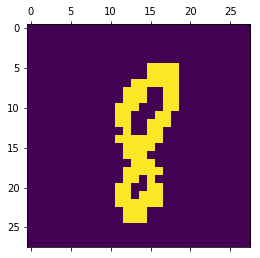

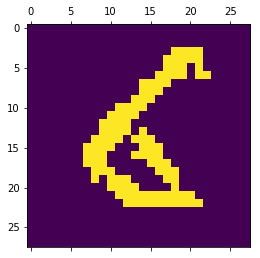

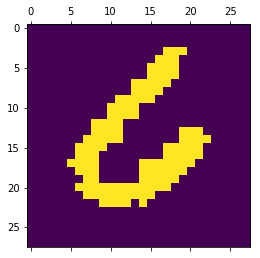

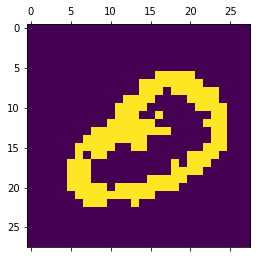

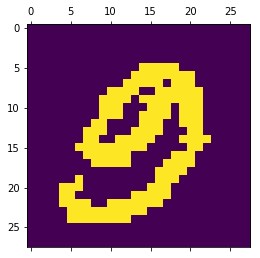

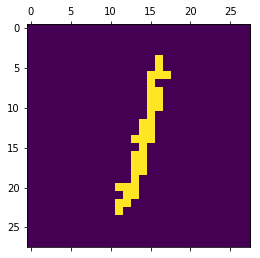

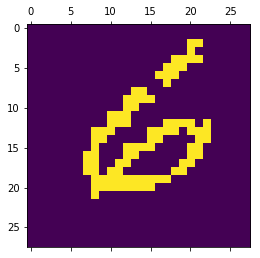

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

In [5]:
slen = train_set_labeled[0]['image'].shape[0]

# Get data loaders

In [6]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [7]:
len(train_loader_unlabeled.sampler)

54

In [8]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [9]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

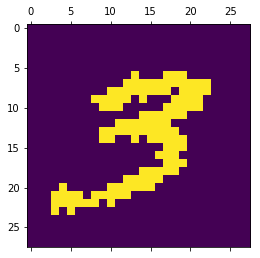

In [10]:
plt.matshow(data_unlabeled['image'][0, :, :])

# Define VAE

In [11]:
latent_dim = 6
n_classes = 10

In [12]:
# vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
#                                     n_classes = n_classes)

vae, classifier = mnist_vae_lib.get_mnist_vae_and_classifier(latent_dim = latent_dim, 
                                                                n_classes = n_classes, 
                                                               slen = slen)

In [13]:
print(vae.parameters)

<bound method Module.parameters of MNISTVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=12, bias=True)
  )
  (decoder): MLPDecoder(
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


In [14]:
print(classifier.parameters)

<bound method Module.parameters of Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=10, bias=True)
  (log_softmax): LogSoftmax()
)>


In [15]:
### Check things run

In [16]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

In [17]:
# check dimensions of encoder output

log_class_weights = classifier(data_unlabeled['image'])
assert log_class_weights.shape[0] == batchsize
assert log_class_weights.shape[1] == n_classes 

latent_means, latent_std = \
    vae.encoder(data_unlabeled['image'], log_class_weights)
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim


In [18]:
cat_rv = torch.distributions.Categorical(probs = torch.exp(log_class_weights))
z_ind = cat_rv.sample()

In [19]:
z_ind

tensor([ 2,  3,  6,  9,  2,  7,  6,  0,  5,  9,  9,  8])

In [20]:
# check one hot encoding 

one_hot_z = vae_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

for n in range(batchsize): 
    foo = one_hot_z[n, :]
    
    assert foo[z_ind[n]] == 1.
    assert sum(foo) == 1.

In [21]:
# check decoder output size 
image_mean = vae.decoder(latent_means, one_hot_z)
assert image_mean.shape[0] == batchsize
assert image_mean.shape[1] == slen
assert image_mean.shape[1] == slen

# Check gradient goes through

In [22]:
lr = 1e-3
weight_decay = 1e-5

In [23]:
optimizer = optim.Adam([
                {'params': classifier.parameters(), 'lr': lr}, #1e-3},
                {'params': vae.parameters(), 'lr': lr}],
                weight_decay=weight_decay)


In [24]:
optimizer.zero_grad()

In [25]:
def get_params(vae): 
    vae_params = torch.Tensor([])
    for f in vae.parameters(): 
        vae_params = torch.cat([vae_params, f[0].view(-1)])
    
    return vae_params


In [26]:
vae_params0 = get_params(vae)
classifier_params0 = get_params(classifier)

In [27]:
log_q = classifier.forward(data_unlabeled['image'])

In [28]:
temperature = 0.5
softmax_sample = gs_lib.gumbel_softmax(log_q, temperature)

In [29]:
unlabeled_gumbel_loss = vae_utils.get_loss_from_one_hot_label(vae, data_unlabeled['image'],
                                                    softmax_sample)

kl_q = torch.sum(torch.exp(log_q) * log_q, dim = 1)

unlabeled_gumbel_loss += kl_q

print(unlabeled_gumbel_loss.sum())

tensor(6494.1899)


In [30]:
unlabeled_gumbel_loss.sum().backward()

In [31]:
optimizer.step()

In [32]:
vae_params1 = get_params(vae)
classifier_params1 = get_params(classifier)

(array([226.,  20.,  85.,  82.,  44.,  65.,  94., 104.,  20., 588.]),
 array([-0.001 , -0.0008, -0.0006, -0.0004, -0.0002,  0.    ,  0.0002,
         0.0004,  0.0006,  0.0008,  0.001 ]),
 <a list of 10 Patch objects>)

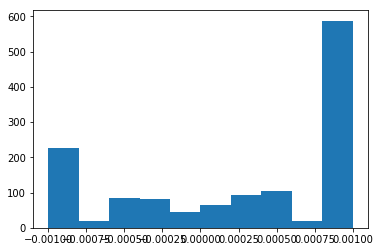

In [33]:
plt.hist((vae_params0 - vae_params1).detach())

(array([379.,  12., 169., 136.,  86.,  87., 119., 174.,  18., 376.]),
 array([-9.99949872e-04, -7.99955055e-04, -5.99960238e-04, -3.99965420e-04,
        -1.99970603e-04,  2.42143869e-08,  2.00019032e-04,  4.00013849e-04,
         6.00008667e-04,  8.00003484e-04,  9.99998301e-04]),
 <a list of 10 Patch objects>)

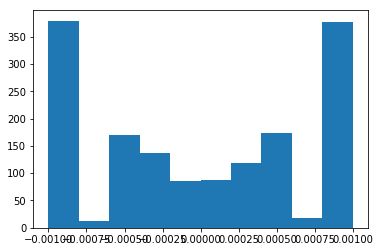

In [34]:
plt.hist((classifier_params0 - classifier_params1).detach())

# Test training

In [35]:
annealing_fun = lambda t : np.maximum(0.5, np.exp(3e-5 * t))

In [36]:
gum_lib.eval_gumbel_vae(vae, classifier, train_loader_unlabeled,
                            loader_labeled = train_loader_labeled,
                            annealing_fun = annealing_fun,
                            optimizer = optimizer, train = True)

(tensor(528.8157), 5)

In [37]:
gum_lib.train_gumbel_vae(vae, classifier,
                train_loader_unlabeled, 
                test_loader, 
                optimizer, 
                annealing_fun,
                train_loader_labeled,
                epochs=10,
                outfile = './mnist_vae_results/test',
                save_every = 5, 
                print_every = 5)

init train loss: 514.9448852539062 || init train accuracy: 0.18518517911434174
init test loss: 512.4474487304688 || init test accuracy: 0.20000000298023224
[1] unlabeled_loss: 484.4145813  	[0.1 seconds]
[2] unlabeled_loss: 384.644989  	[0.1 seconds]
[3] unlabeled_loss: 304.5475769  	[0.1 seconds]
[4] unlabeled_loss: 254.2144165  	[0.1 seconds]
[5] unlabeled_loss: 233.7227173  	[0.1 seconds]
train loss: 233.65048217773438 || test loss: 233.56143188476562
train accuracy: 0.09259258955717087 || test accuracy: 0.20000000298023224
writing the vae parameters to ./mnist_vae_results/test_vae_epoch5

writing the classifier parameters to ./mnist_vae_results/test_classifier_epoch5

[6] unlabeled_loss: 229.821228  	[0.1 seconds]
[7] unlabeled_loss: 223.2601929  	[0.1 seconds]
[8] unlabeled_loss: 218.9242554  	[0.2 seconds]
[9] unlabeled_loss: 216.7388611  	[0.1 seconds]
[10] unlabeled_loss: 215.9855194  	[0.1 seconds]
train loss: 216.6438446044922 || test loss: 222.5267791748047
train accuracy: 0